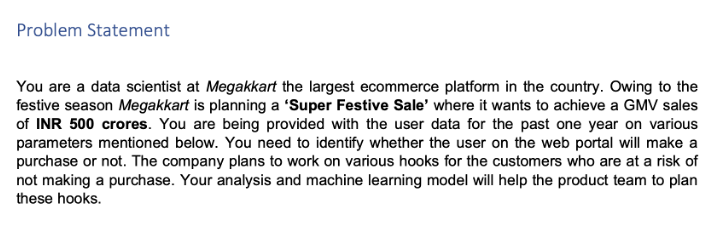

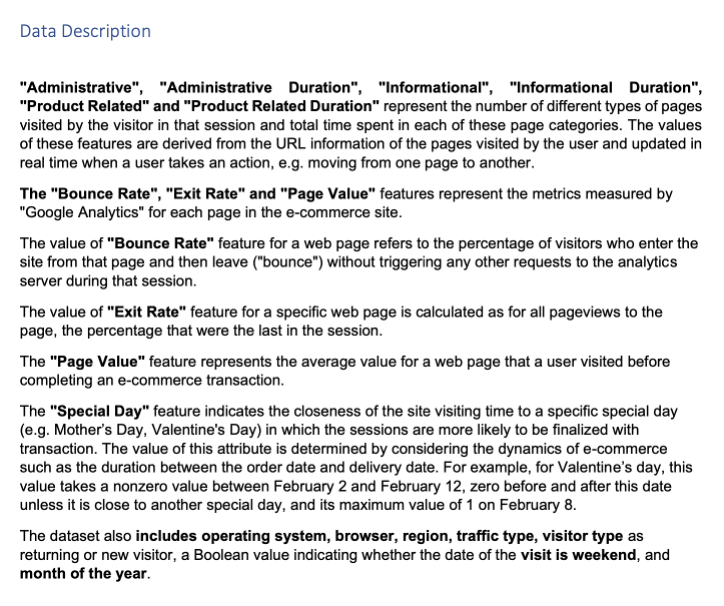

## Table of Contents

* [Data Aquisition](#ml_pipeline1)
* [Data Cleaning & Preprocessing](#ml_pipeline2)
* [Exploratory Data Analysis](#ml_pipeline3)
* [Feature Engineering](#ml_pipeline4)
* [Model Training & Evaluation](#ml_pipeline5)
* [Model Tuning & Evaluation](#ml_pipeline6)
* [Model Prediction on Live Data](#ml_pipeline7)







## 1. Dataset Aquisition <a class="anchor" id="ml_pipeline1"></a>



In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import statistics

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [2]:
# Read data file

df_train = pd.read_csv('ecommerce_train.csv')
df_test_live = pd.read_csv('ecommerce_test.csv')

df_train.head(3)

,session_id,administrative,administrative_duration,informational,informational_duration,productrelated,productrelated_duration,bouncerates,exitrates,pagevalues,specialday,month,operatingsystems,browser,region,traffictype,visitortype,weekend,revenue
0,139957,2,47.5,0,0.0,19,1203.480714,0.000000,0.027421,6.748509,0.0,Nov,2,2,3,2,Returning_Visitor,False,0
1,496587,0,0.0,0,0.0,7,152.000000,0.000000,0.033333,0.000000,0.0,Dec,3,2,6,3,Returning_Visitor,False,0
2,440268,7,206.5,1,389.9,95,4415.889952,0.000133,0.033750,2.676062,0.0,Nov,2,2,1,20,Returning_Visitor,False,0


In [3]:
df_test_live.head(2)

,session_id,administrative,administrative_duration,informational,informational_duration,productrelated,productrelated_duration,bouncerates,exitrates,pagevalues,specialday,month,operatingsystems,browser,region,traffictype,visitortype,weekend
0,283149,0,0.0,0,0.0,10,388.0,0.000000,0.014286,0.0,0.0,Nov,1,2,8,2,New_Visitor,False
1,253020,0,0.0,0,0.0,17,142.4,0.017707,0.044623,0.0,0.0,Nov,1,2,3,8,New_Visitor,False


## 2. Dataset Cleaning and Preprocessing <a class="anchor" id="ml_pipeline2"></a>


<font color=blue>*Shape of Dataset*

- There are 40000 samples and 19 features for training.
- There are 10000 samples and 18 features for test as this excludes the label.

In [4]:
print('Training', df_train.shape)
print('Test', df_test_live.shape)

Training (40000, 19)
Test (10000, 18)


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   session_id               40000 non-null  int64  
 1   administrative           40000 non-null  int64  
 2   administrative_duration  40000 non-null  float64
 3   informational            40000 non-null  int64  
 4   informational_duration   40000 non-null  float64
 5   productrelated           40000 non-null  int64  
 6   productrelated_duration  40000 non-null  float64
 7   bouncerates              40000 non-null  float64
 8   exitrates                40000 non-null  float64
 9   pagevalues               40000 non-null  float64
 10  specialday               40000 non-null  float64
 11  month                    40000 non-null  object 
 12  operatingsystems         40000 non-null  object 
 13  browser                  40000 non-null  object 
 14  region                

<font color=blue>*Data Types*
    
As data types seem to correctly interpreted by python no conversion required only some categorical variables would be encoded for modelling.

In [6]:
categorical_features = df_train.select_dtypes(include="object").columns
categorical_features

Index(['month', 'operatingsystems', 'browser', 'traffictype', 'visitortype'], dtype='object')

In [7]:
df_train.select_dtypes("object").nunique()


month               10
operatingsystems     6
browser             11
traffictype         15
visitortype          3
dtype: int64

In [8]:
numerical_features = df_train.select_dtypes(include=['float64','int64']).columns
numerical_features

Index(['session_id', 'administrative', 'administrative_duration',
       'informational', 'informational_duration', 'productrelated',
       'productrelated_duration', 'bouncerates', 'exitrates', 'pagevalues',
       'specialday', 'region', 'revenue'],
      dtype='object')

In [9]:
boolean_features = df_train.select_dtypes(include="bool").columns
boolean_features

Index(['weekend'], dtype='object')

<font color=blue>*Check for Missing / Duplicate Values*


In [10]:
missing_values = df_train.isnull().sum()
missing_values

session_id                 0
administrative             0
administrative_duration    0
informational              0
informational_duration     0
productrelated             0
productrelated_duration    0
bouncerates                0
exitrates                  0
pagevalues                 0
specialday                 0
month                      0
operatingsystems           0
browser                    0
region                     0
traffictype                0
visitortype                0
weekend                    0
revenue                    0
dtype: int64

*It shows no missing values in any columns however need to check why operatingsystems, browser, traffictype detected as object when it is already encoded as numbers in given data, it might be due to some special chacaters which can be replaced with 'nan' if found.*

**Duplicates**

In [11]:
duplicates = df_train[df_train.duplicated()]
len(duplicates)

0

In [12]:
# Unique Values in each categorical column to check for any special character-
cat_cols = ['operatingsystems','browser','traffictype']

for i in df_train[cat_cols]:
    print("\033[1m" + i + "\033[0m")
    print('Unique values:',df_train[i].unique())
    print('Total unique values:',df_train[i].nunique(),'\n')
    

operatingsystems
Unique values: ['2' '3' '1' '4' '8' '*']
Total unique values: 6 

browser
Unique values: ['2' '1' '10' '5' '7' '4' '8' '3' '6' '*' '13']
Total unique values: 11 

traffictype
Unique values: ['2' '3' '20' '1' '4' '11' '6' '13' '5' '*' '10' '8' '15' '7' '9']
Total unique values: 15 



**Note**


Since all of them contains a special character * hence detected as object data type. So we replace * with nan and then fill nan with mode value.

In [13]:
def chk_miss_count(df):
    
    os_miss = (len(df[df['operatingsystems'] == '*']))
    br_miss = (len(df[df['browser'] == '*']))
    tf_miss = (len(df[df['traffictype'] == '*']))
    total_miss = (os_miss + br_miss + tf_miss)
    print('Total rows with missing values = ', total_miss)
    
chk_miss_count(df_train)  # call function
chk_miss_count(df_test_live)  # call function

Total rows with missing values =  255
Total rows with missing values =  77


<font color=blue>*Handling Missing Values*  
    

In [14]:
cols = ['operatingsystems','browser','traffictype']

df_train[cols] = df_train[cols].replace('*', np.nan)  # replace * with nan
df_train[cols]= df_train[cols].fillna(df_train[cols].mode().iloc[0])  # fill nan with mode
chk_miss_count(df_train)   # call function


Total rows with missing values =  0


In [15]:
df_test_live[cols] = df_test_live[cols].replace('*', np.nan)  # replace * with nan
df_test_live[cols]= df_test_live[cols].fillna(df_train[cols].mode().iloc[0]) 
chk_miss_count(df_test_live)   # call function



Total rows with missing values =  0


<font color=blue>*Descriptive summary of dataset*  


In [16]:
df_train.describe()   


,session_id,administrative,administrative_duration,informational,informational_duration,productrelated,productrelated_duration,bouncerates,exitrates,pagevalues,specialday,region,revenue
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,311469.372075,2.544150,89.794383,0.555225,40.977236,34.026975,1148.105672,0.021969,0.042307,6.494963,0.063552,3.241975,0.158275
std,108498.432497,3.667252,182.964645,1.332627,153.114387,46.798102,1666.181462,0.048533,0.048633,17.710646,0.199463,2.423586,0.365003
min,123460.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,217950.000000,0.000000,0.000000,0.000000,0.000000,7.000000,183.883333,0.000000,0.013389,0.000000,0.000000,1.000000,0.000000
50%,311194.500000,1.000000,11.200000,0.000000,0.000000,19.000000,560.075000,0.003304,0.025000,0.000000,0.000000,3.000000,0.000000
75%,404680.500000,4.000000,110.154167,0.000000,0.000000,41.000000,1420.536667,0.016667,0.050000,0.000000,0.000000,4.000000,0.000000
max,499982.000000,22.000000,1946.000000,11.000000,1767.666667,440.000000,18504.126210,0.200000,0.200000,226.677702,1.000000,9.000000,1.000000


In [17]:
df_train.describe(include='O')   


,month,operatingsystems,browser,traffictype,visitortype
count,40000,40000,40000,40000,40000
unique,10,5,10,14,3
top,May,2,2,2,Returning_Visitor
freq,11048,21723,25590,12665,34496


## 3. Exploratory Data Analysis <a class="anchor" id="ml_pipeline3"></a>


### 1. Distribution of Target Variable

In [18]:
import matplotlib.pyplot as plt

revenue1 = df_train['revenue'].value_counts()
revenue1

0    33669
1     6331
Name: revenue, dtype: int64

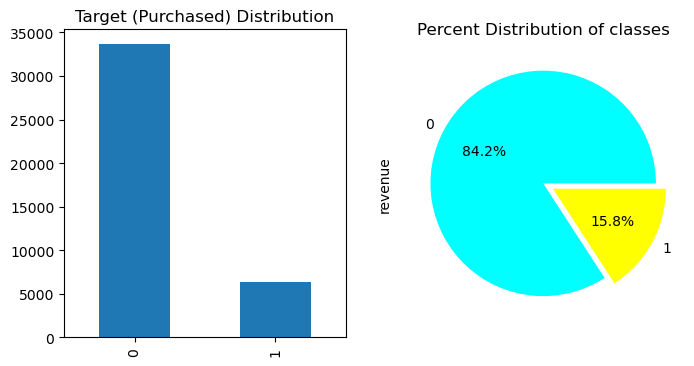

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1,ncols=2)

explode=(0,0.1)
revenue1.plot(kind='bar',title=('Target (Purchased) Distribution'),figsize=(5,3), ax=ax[0])
revenue1.plot(kind='pie', title='Percent Distribution of classes',explode=explode,autopct='%1.1f%%', colors=['cyan','yellow'],
              figsize=(8,4), ax=ax[1]);




### 2. Univariate Plots for Categorical Features to check distributions

*Histogram, Density plot, Box plot, Bar plot, Pie chart, Violin plot, Scatter plot*

In [20]:
# Unique Values in each categorical column-
cat_cols = ['month', 'operatingsystems', 'browser', 'region', 'traffictype', 'visitortype', 
            'weekend', 'revenue']

for i in df_train[cat_cols]:
    print("\033[1m" + i + "\033[0m")
    print('Unique values:',df_train[i].unique())
    print('Total unique values:',df_train[i].nunique(),'\n')
    

month
Unique values: ['Nov' 'Dec' 'May' 'June' 'Mar' 'Sep' 'Aug' 'Oct' 'Jul' 'Feb']
Total unique values: 10 

operatingsystems
Unique values: ['2' '3' '1' '4' '8']
Total unique values: 5 

browser
Unique values: ['2' '1' '10' '5' '7' '4' '8' '3' '6' '13']
Total unique values: 10 

region
Unique values: [3 6 1 5 7 4 2 8 9]
Total unique values: 9 

traffictype
Unique values: ['2' '3' '20' '1' '4' '11' '6' '13' '5' '10' '8' '15' '7' '9']
Total unique values: 14 

visitortype
Unique values: ['Returning_Visitor' 'New_Visitor' 'Other']
Total unique values: 3 

weekend
Unique values: [False  True]
Total unique values: 2 

revenue
Unique values: [0 1]
Total unique values: 2 



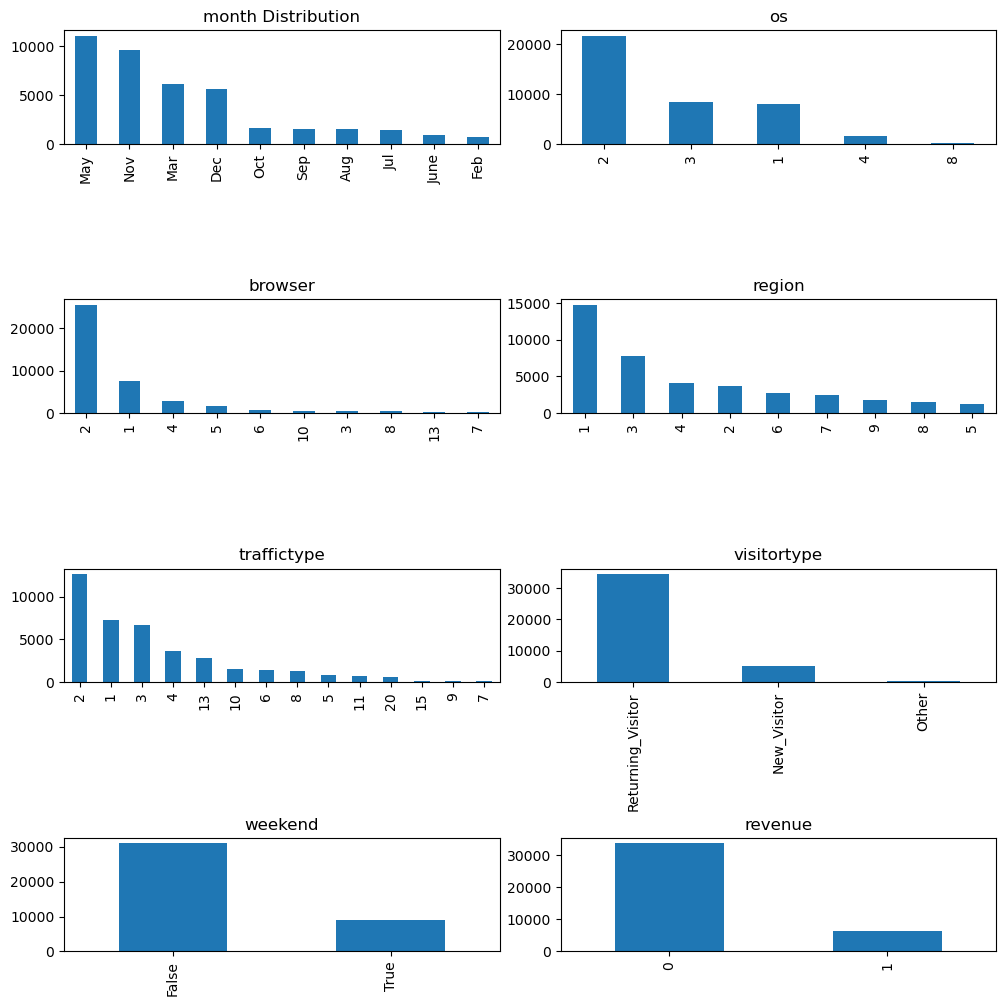

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=4,ncols=2,figsize=(10,10))

df_train['month'].value_counts().plot(kind='bar',title=('month Distribution'),ax=ax[0,0])
df_train['operatingsystems'].value_counts().plot(kind='bar',title=('os'), ax=ax[0,1])
df_train['browser'].value_counts().plot(kind='bar',title=('browser'), ax=ax[1,0])
df_train['region'].value_counts().plot(kind='bar',title=('region'), ax=ax[1,1])
df_train['traffictype'].value_counts().plot(kind='bar',title=('traffictype'), ax=ax[2,0])
df_train['visitortype'].value_counts().plot(kind='bar',title=('visitortype'), ax=ax[2,1])
df_train['weekend'].value_counts().plot(kind='bar',title=('weekend'), ax=ax[3,0])
df_train['revenue'].value_counts().plot(kind='bar',title=('revenue'), ax=ax[3,1])

fig.tight_layout(pad=0.5)
plt.show()

**Analysis**

1. Distribution of revenue (purchased) is imbalanced.
2. May and Nov are the months with most traffic.
3. Top 3 regions of login are 1,3,4.
4. Traffic type 2,1 and 3 is maximum.
5. Most of people are Returning_Visitor compared to new ones.
6. More people visit online on weekdays rather than weekends


### 3. Bivariate Analysis w.r.t revenue target variable

We check how revenue is affected w.r.t month, region, traffic type, Visitor type, weekend

*Scatter plot, Line plot, Bar plot, Heatmap, Contour plot, Bubble plot,Hexbin plot*

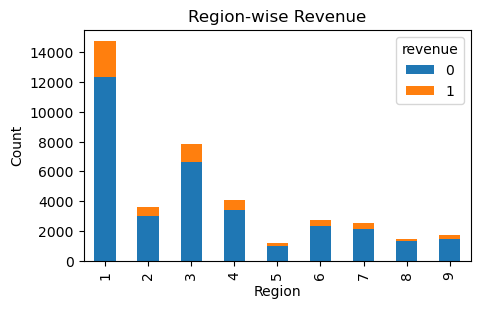

In [22]:
# Group by 'Region' and calculate the count of revenue values (0 and 1) for each group
df_counts = df_train.groupby('region')['revenue'].value_counts().unstack()

# Create a stacked bar chart
ax = df_counts.plot(kind='bar', stacked=True,figsize=(5,3))

# Add title and axis labels
ax.set_title('Region-wise Revenue')
ax.set_xlabel('Region')
ax.set_ylabel('Count')

# Show the chart
plt.show()

In [23]:
df_counts['prcnt_buy'] = (df_counts[1]/(df_counts[0]+df_counts[1])*100)


In [24]:
df_counts

revenue,0,1,prcnt_buy
region,,,
1,12337,2412,16.353651
2,3031,611,16.776496
3,6644,1189,15.179369
4,3433,613,15.150766
5,994,208,17.304493
6,2325,430,15.607985
7,2147,376,14.902893
8,1322,166,11.155914
9,1436,326,18.501703


Although count of users on web portal from region 1 are maximum however it is in region 9 that many customers actually make a purchase which is 18.5%.

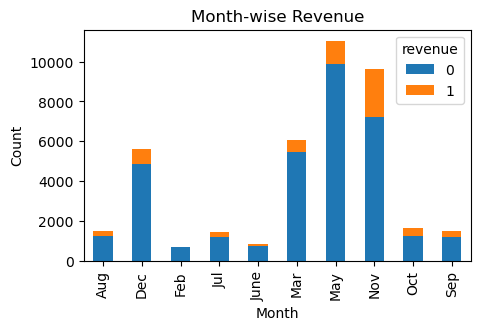

In [25]:
# Group by 'Month' and calculate the count of revenue values (0 and 1) for each group
df_counts1 = df_train.groupby('month')['revenue'].value_counts().unstack()


# Create a stacked bar chart
ax = df_counts1.plot(kind='bar', stacked=True, figsize=(5,3))

# Add title and axis labels
ax.set_title('Month-wise Revenue')
ax.set_xlabel('Month')
ax.set_ylabel('Count')

# Show the chart
plt.show()

In [26]:
df_counts1['prcnt_buy'] = (df_counts1[1]/(df_counts1[0]+df_counts1[1])*100)
df_counts1

revenue,0,1,prcnt_buy
month,,,
Aug,1223,251,17.028494
Dec,4837,784,13.947696
Feb,664,32,4.597701
Jul,1209,220,15.395381
June,756,101,11.785298
Mar,5451,635,10.433782
May,9864,1184,10.716872
Nov,7218,2407,25.007792
Oct,1264,397,23.901264


Customers visiting portal as well as making a purchase are highest in November.

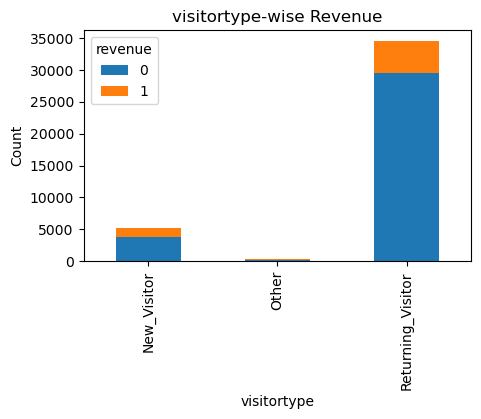

In [27]:
# Group by 'Region' and calculate the count of revenue values (0 and 1) for each group
df_counts2 = df_train.groupby('visitortype')['revenue'].value_counts().unstack()

# Create a stacked bar chart
ax = df_counts2.plot(kind='bar', stacked=True,figsize=(5,3))

# Add title and axis labels
ax.set_title('visitortype-wise Revenue')
ax.set_xlabel('visitortype')
ax.set_ylabel('Count')

# Show the chart
plt.show()

In [28]:
df_counts2['prcnt_buy'] = (df_counts2[1]/(df_counts2[0]+df_counts2[1])*100)
df_counts2

revenue,0,1,prcnt_buy
visitortype,,,
New_Visitor,3856,1368,26.186830
Other,245,35,12.500000
Returning_Visitor,29568,4928,14.285714


26% out of all new visitors make a purchase while only 14% of all returning visitors make a purchase. 

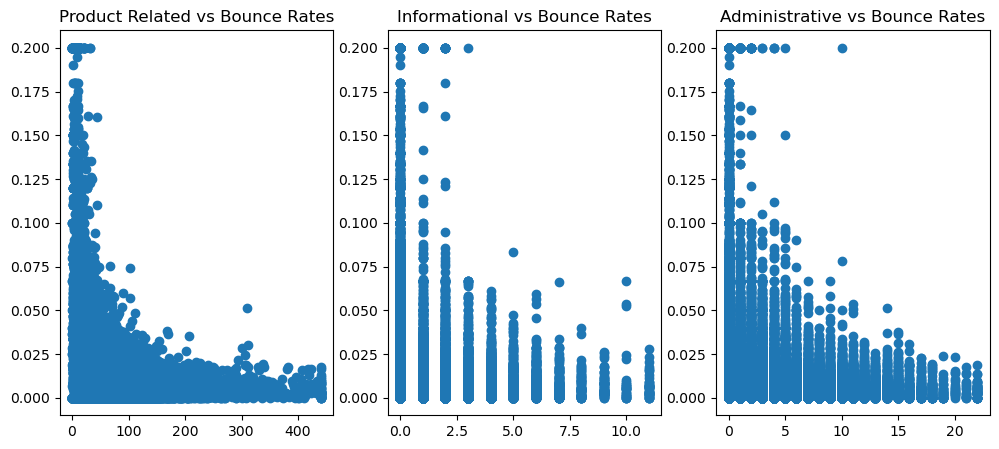

In [29]:
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(12,5))

ax[0].scatter(df_train['productrelated'], df_train['bouncerates'])
ax[1].scatter(df_train['informational'], df_train['bouncerates'])
ax[2].scatter(df_train['administrative'], df_train['bouncerates'])
ax[0].set_title('Product Related vs Bounce Rates')
ax[1].set_title('Informational vs Bounce Rates')
ax[2].set_title('Administrative vs Bounce Rates')


plt.show()

It seems bounce rates are generally high when count of pages is low. Bounce rates drop when count of pages are more.

## 4. Feature Engineering <a class="anchor" id="ml_pipeline4"></a>


In [30]:
corr_matrix = df_train.corr()


/var/folders/1j/6bqwtp0x00z_279498pht7ym0000gn/T/ipykernel_76613/2666808738.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_train.corr()


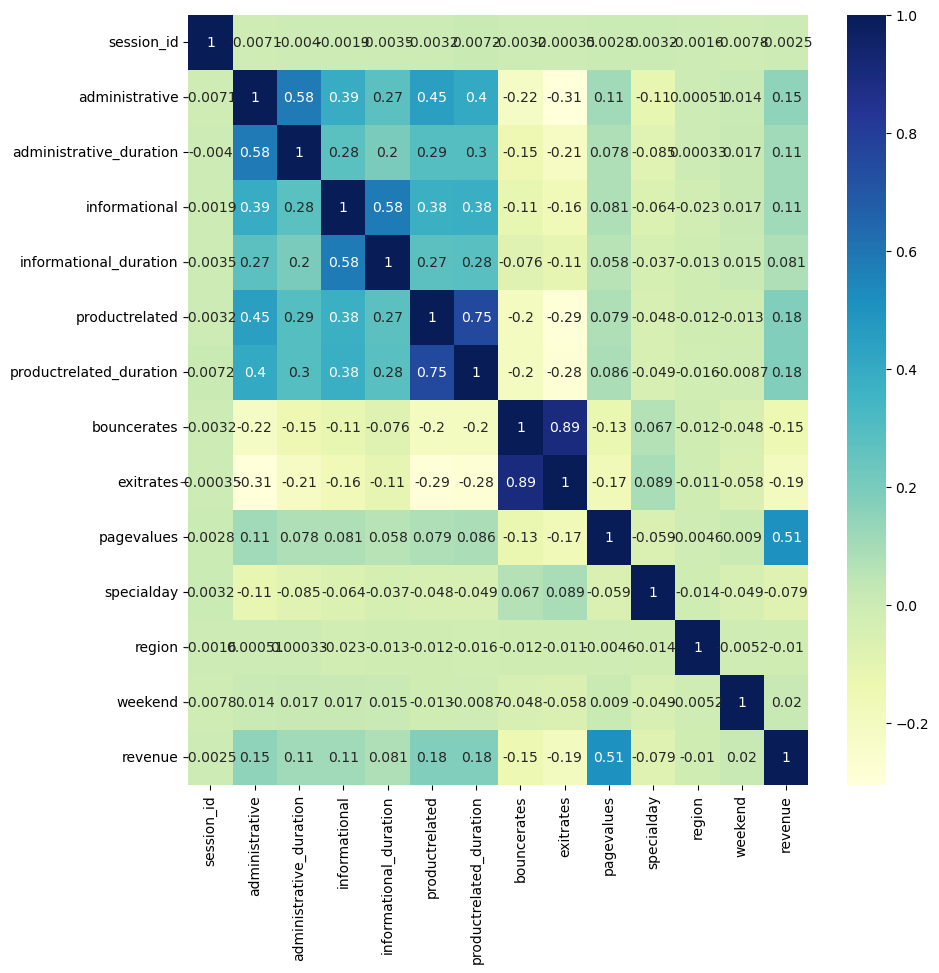

In [31]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr_matrix, cmap="YlGnBu",annot=True);

- Multicollinearity is the occurrence of high intercorrelations among two or more independent variables which can make the statistical inferences less reliable. 
- To avoid Multicollinearity problem, we drop the administrative_duration, informational_duration, productrelated_duration which are correlated with administrative, informational & productrelated counts.

In [32]:
df_train = df_train.drop(['session_id','administrative_duration','productrelated_duration',
                          'informational_duration','exitrates'],axis=1)


# keep session id's before drop column for rzlt
df_test_live_sess = df_test_live['session_id'] 

df_test_live = df_test_live.drop(['session_id','administrative_duration','productrelated_duration',
                          'informational_duration','exitrates'],axis=1)


df_train.columns


Index(['administrative', 'informational', 'productrelated', 'bouncerates',
       'pagevalues', 'specialday', 'month', 'operatingsystems', 'browser',
       'region', 'traffictype', 'visitortype', 'weekend', 'revenue'],
      dtype='object')

In [33]:
# Split Data into Train and Test and encode features before Modelling

from sklearn.model_selection import train_test_split

# create dependent and independent feature sets
X = df_train.drop(columns='revenue')
y = df_train['revenue']


# spilt the data set in training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 33)


In [34]:
X_train.head(2)

,administrative,informational,productrelated,bouncerates,pagevalues,specialday,month,operatingsystems,browser,region,traffictype,visitortype,weekend
36313,0,0,9,0.0,0.0,0.0,Dec,1,1,1,1,Returning_Visitor,True
9721,0,0,5,0.0,0.0,0.0,Mar,2,2,2,3,Returning_Visitor,False


**Label Encoding**

In [35]:
from sklearn.preprocessing import LabelEncoder

cols_le = ['month']

for i in cols_le:
    le = LabelEncoder()
    X_train[i] = le.fit_transform(X_train[i])
    X_test[i] = le.transform(X_test[i])
    df_test_live[i] = le.transform(df_test_live[i])
    

**One Hot encoding**

In [36]:
from sklearn.preprocessing import OneHotEncoder

def ohe_cols(df,col_name):
    ohe = OneHotEncoder()
    col_2d_array = df[col_name].values.reshape(-1, 1)
    ohe_col = ohe.fit_transform(col_2d_array)  # series to 2D array
    ohe_col = ohe_col.toarray()  # sparse to dense
    ohe_col_df = pd.DataFrame(ohe_col, columns=ohe.get_feature_names_out([col_name]))#newdf

    return ohe_col_df


In [37]:
X_train_col1 = ohe_cols(X_train,'visitortype')
X_train_col2 = ohe_cols(X_train,'weekend')

X_test_col1 = ohe_cols(X_test,'visitortype')
X_test_col2 = ohe_cols(X_test,'weekend')

df_test_live_col1 = ohe_cols(df_test_live,'visitortype')
df_test_live_col2 = ohe_cols(df_test_live,'weekend')


In [38]:
X_train_ohe = pd.concat([X_train.reset_index(drop=False), X_train_col1.reset_index(drop=True),X_train_col2.reset_index(drop=True)], axis=1)
X_train_ohe = X_train_ohe.set_index('index')
X_train_ohe = X_train_ohe.drop(['visitortype','weekend'],axis=1)


X_test_ohe = pd.concat([X_test.reset_index(drop=False), X_test_col1.reset_index(drop=True),X_test_col2.reset_index(drop=True)], axis=1)
X_test_ohe = X_test_ohe.set_index('index')
X_test_ohe = X_test_ohe.drop(['visitortype','weekend'],axis=1)


df_test_live_ohe = pd.concat([df_test_live.reset_index(drop=False), df_test_live_col1.reset_index(drop=True),df_test_live_col2.reset_index(drop=True)], axis=1)
df_test_live_ohe = df_test_live_ohe.set_index('index')
df_test_live_ohe = df_test_live_ohe.drop(['visitortype','weekend'],axis=1)



In [39]:
X_train_ohe.head(2)

,administrative,informational,productrelated,bouncerates,pagevalues,specialday,month,operatingsystems,browser,region,traffictype,visitortype_New_Visitor,visitortype_Other,visitortype_Returning_Visitor,weekend_False,weekend_True
index,,,,,,,,,,,,,,,,
36313,0,0,9,0.0,0.0,0.0,1,1,1,1,1,0.0,0.0,1.0,0.0,1.0
9721,0,0,5,0.0,0.0,0.0,5,2,2,2,3,0.0,0.0,1.0,1.0,0.0


**Feature Scaling**

In [40]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_arr = scaler.fit_transform(X_train_ohe)
X_train_df = pd.DataFrame(X_train_arr, columns=X_train_ohe.columns)

X_test_arr = scaler.transform(X_test_ohe)
X_test_df = pd.DataFrame(X_test_arr, columns=X_test_ohe.columns)

df_test_live_arr = scaler.transform(df_test_live_ohe)
df_test_live_df = pd.DataFrame(df_test_live_arr, columns=df_test_live_ohe.columns)


In [41]:
X_train_df.head(2)

,administrative,informational,productrelated,bouncerates,pagevalues,specialday,month,operatingsystems,browser,region,traffictype,visitortype_New_Visitor,visitortype_Other,visitortype_Returning_Visitor,weekend_False,weekend_True
0,-0.693436,-0.416191,-0.533531,-0.451203,-0.3675,-0.318251,-1.736941,-1.273441,-0.819755,-0.921842,-0.792732,-0.38757,-0.085085,0.399748,-1.866798,1.866798
1,-0.693436,-0.416191,-0.619200,-0.451203,-0.3675,-0.318251,-0.060534,-0.137771,-0.231880,-0.509633,-0.292837,-0.38757,-0.085085,0.399748,0.535677,-0.535677


- X_train_arr and y_train will be used for training.
- X_test_arr and y_test will be used for testing and evaluation.
- Finally the selected model will be used for predictions on df_test_live_arr to get y_test_live with unknown labels.

In [42]:
print(len(X_train_arr),len(X_test_arr),len(y_train),len(y_test),len(df_test_live_arr))

32000 8000 32000 8000 10000


## 5. Model Training and Evaluation <a class="anchor" id="ml_pipeline5"></a>


*<font color=blue>We try the below classification algorithms with default parameters initially to select a few which can further be selected for optimization.*

In [43]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix
from mlxtend.plotting import plot_confusion_matrix  


## Generalized Function (based on default parameters of all algorithms) 

In [44]:
def ml_model(model):
    
    # Fit
    model.fit(X_train_arr, y_train)

    # Predict
    y_pred_train = model.predict(X_train_arr)
    y_pred_test = model.predict(X_test_arr)

    # Evaluate
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_train = f1_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)
    
    return acc_train,acc_test,f1_train,f1_test


In [45]:
# ML Algorithms from scikit learn

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier


In [46]:
# Instantiate to get a model

logr = LogisticRegression()
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier(random_state=80)   
rf = RandomForestClassifier(random_state=80)
nb_guassian = GaussianNB()
svm_clf = svm.SVC()
mlp = MLPClassifier()


In [47]:
# Call function to get accuracy and f1 score

acc_train_lr, acc_test_lr, f1_train_lr, f1_test_lr =  ml_model(logr)
acc_train_knn, acc_test_knn, f1_train_knn, f1_test_knn =  ml_model(knn)
acc_train_dt, acc_test_dt, f1_train_dt, f1_test_dt =  ml_model(dtree)
acc_train_rf, acc_test_rf, f1_train_rf, f1_test_rf =  ml_model(rf)
acc_train_nb, acc_test_nb, f1_train_nb, f1_test_nb  =  ml_model(nb_guassian)
acc_train_svm, acc_test_svm, f1_train_svm, f1_test_svm  =  ml_model(svm_clf)
acc_train_mlp, acc_test_mlp, f1_train_mlp, f1_test_mlp =  ml_model(mlp)


# Default Values for mlp ----------------------------------------------
## hidden_layer_sizesarray-like of shape(n_layers - 2,), default=(100,)
## activation{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
## solver{‘lbfgs’, ‘sgd’, ‘adam’}, default=’adam’
## max_iterint, default=200
# alphafloat, default=0.0001
# batch_sizeint, default=’auto’
# learning_rate{‘constant’, ‘invscaling’, ‘adaptive’}, default=’constant’
# learning_rate_initfloat, default=0.001



In [48]:
df = pd.DataFrame({'Model_Name': ['Logistic Regression', 'K-Nearest neighbors', 'Decision_Tree',
                                  'Random_Forest','Naive_Bayes','Support Vector Machine',
                                  'Multi-layer Perceptron'],
                   'Accuracy_Train': [acc_train_lr, acc_train_knn, acc_train_dt, acc_train_rf,
                                     acc_train_nb,acc_train_svm,acc_train_mlp],
                   'F1_Train': [f1_train_lr, f1_train_knn, f1_train_dt,f1_train_rf,
                                f1_train_nb,f1_train_svm, f1_train_mlp],
                   'Accuracy_Test': [acc_test_lr, acc_test_knn, acc_test_dt, acc_test_rf,
                                     acc_test_nb,acc_test_svm,acc_test_mlp],
                   'F1_Test': [f1_test_lr, f1_test_knn, f1_test_dt,f1_test_rf,
                                f1_test_nb,f1_test_svm, f1_test_mlp]})

sorted_df = df.sort_values(['Accuracy_Train', 'F1_Train','Accuracy_Test','F1_Test'], 
                           ascending=[False, False,False,False])

sorted_df


,Model_Name,Accuracy_Train,F1_Train,Accuracy_Test,F1_Test
2,Decision_Tree,0.999875,0.999605,0.862125,0.575606
3,Random_Forest,0.999844,0.999506,0.901875,0.667514
6,Multi-layer Perceptron,0.908937,0.693586,0.897000,0.657238
1,K-Nearest neighbors,0.906312,0.658309,0.870000,0.520737
5,Support Vector Machine,0.896656,0.609978,0.892125,0.593882
0,Logistic Regression,0.875469,0.480240,0.875750,0.483368
4,Naive_Bayes,0.768625,0.465955,0.771125,0.473699


Tree-based models which is Decision tree and Random Forest are overfitting as there is a lot of difference b/w train and test accuracy. MLP has almost similar train and test accuracy & hence is not overfitting. 

## 6. Model Tuning and Evaluation <a class="anchor" id="ml_pipeline6"></a>


*<font color=blue>We pick the top 2 performing models from above and do hyperparameter tuning and cross valiadation for these 2 models to get the best one.*

* [Random Forest](#classify1)
* [Multi-Layer Perceptron](#classify2)

    

In [49]:
#pip install scikit-plot


In [50]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV,cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, f1_score,classification_report
from scikitplot.metrics import plot_roc



## Random Forest <a class="anchor" id="classify1"></a>


In [51]:

# define hyperparameters to tune
params =     {'n_estimators' : [20, 50, 100, 150, 200],
              'max_depth': [5, 10, 15]}



rf_gs = GridSearchCV(estimator=rf, 
                      param_grid=params, # parameters in which we want to search optimal values
                      scoring='accuracy', 
                      cv=5).fit(X_train_arr, y_train)


# Print the best hyperparameters and evaluation scores
print('Best hyperparameters:', rf_gs.best_params_)
print('Best Accuracy score:', rf_gs.best_score_)
                                   

Best hyperparameters: {'max_depth': 10, 'n_estimators': 150}
Best Accuracy score: 0.90353125


In [52]:
rf_optimized = rf_gs.best_estimator_

y_pred_rfo_train = rf_optimized.predict(X_train_arr) 

y_pred_rfo_test = rf_optimized.predict(X_test_arr) 

acc_rfo_train = accuracy_score(y_train, y_pred_rfo_train)
acc_rfo_test = accuracy_score(y_test, y_pred_rfo_test)

f1_rfo_train = f1_score(y_train, y_pred_rfo_train)
f1_rfo_test = f1_score(y_test, y_pred_rfo_test)


print('Accuracy score with Random Forest train & test',round(acc_rfo_train,3),round(acc_rfo_test,3))
print('F1 score with Random Forest train & test',round(f1_rfo_train,3),round(f1_rfo_test,3))


Accuracy score with Random Forest train & test 0.924 0.903
F1 score with Random Forest train & test 0.743 0.674


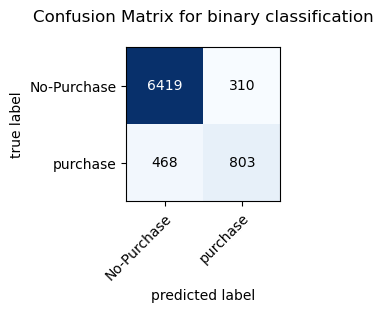

In [54]:
# Confusion Matrix
cm_rfo_train = confusion_matrix(y_train, y_pred_rfo_train,labels=(0,1))
cm_rfo_test = confusion_matrix(y_test, y_pred_rfo_test,labels=(0,1))


fig = plot_confusion_matrix(cm_rfo_test, class_names=['No-Purchase','purchase'],figsize=(2,2))
plt.title("Confusion Matrix for binary classification\n")
plt.show();

In [55]:
print(classification_report(y_test, y_pred_rfo_test))


              precision    recall  f1-score   support

           0       0.93      0.95      0.94      6729
           1       0.72      0.63      0.67      1271

    accuracy                           0.90      8000
   macro avg       0.83      0.79      0.81      8000
weighted avg       0.90      0.90      0.90      8000



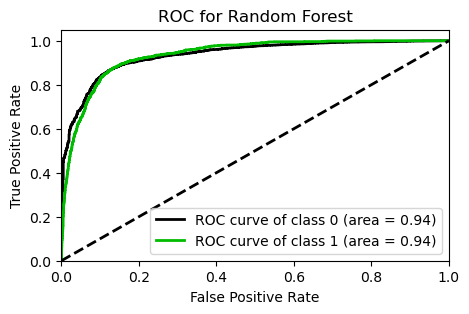

In [56]:
y_predproba_rfo =  rf_optimized.predict_proba(X_test_arr) 

plot_roc(y_test,y_predproba_rfo,figsize=(5,3),title='ROC for Random Forest',
        plot_micro=False,
        plot_macro=False);

## Multi-layer Perceptron <a class="anchor" id="classify2"></a>


Loss curve on default parameters to get an idea of how many iterations might be required for convergence to put for further hyperparameter tuning. In default parameters of scikit learn for mlp, default iterations=200 hence we are seeing graph here till 200 (as we built with mlp classifier with default parameters) and here we see loss is reducing until 200. Maybe increasing iterations a bit more during hyperparameter tuning can improve accuracy futher.

In [ ]:
plt.figure(figsize=(4,3))
plt.plot(mlp.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

From above loss curve we get an idea of how many iterations might be required for convergence.

In [ ]:
# Define the hyperparameter grid
param_grid = {
    'hidden_layer_sizes': [(20,10), (15,5)],
    'max_iter': [150, 200, 150],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.01, 0.05],
    'learning_rate': ['adaptive']
}


mlp_gs = GridSearchCV(estimator=mlp, 
                           param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=5).fit(X_train_arr, y_train)


# hidden_layers=2, 1st combination 20,10 another combination to try is 15,5
# Number of hidden layers is 2
# For 3 hiddenlayers [(20,10,5), (15,5,2)]

In [ ]:
# Print the best hyperparameters and evaluation scores
print('Best hyperparameters:', mlp_gs.best_params_)
print('Best Accuracy score:', mlp_gs.best_score_)


In [ ]:
mlp_optimized = mlp_gs.best_estimator_

y_pred_mlpo = mlp_optimized.predict(X_test_arr) 


acc_mlpo = accuracy_score(y_test, y_pred_mlpo)
f1_mlpo = f1_score(y_test, y_pred_mlpo)

print('Accuracy score with mlp',round(acc_mlpo,3))
print('F1 score with mlp',round(f1_mlpo,3))

In [ ]:
# Confusion Matrix
cm_mlpo = confusion_matrix(y_test, y_pred_mlpo,labels=(0,1))

fig = plot_confusion_matrix(cm_mlpo, class_names=['No-Purchase','purchase'],figsize=(2,2))
plt.title("Confusion Matrix for binary classification\n")
plt.show();

In [ ]:
print(classification_report(y_test, y_pred_mlpo))


In [ ]:
y_predproba_mlpo =  mlp_optimized.predict_proba(X_test_arr) 

plot_roc(y_test,y_predproba_mlpo,figsize=(5,3),title='ROC for MLP',
        plot_micro=False,
        plot_macro=False);


## 7. Prediction on Live Test <a class="anchor" id="ml_pipeline7"></a>


Out of the 2 models, random forest gives better accuracy and F1 score hence we use that model for prediction on live test data.

In [ ]:
df_test_live_df.head(2)

In [ ]:
y_pred_rfo = rf_optimized.predict(df_test_live_arr) 
y_pred_rfo

In [ ]:
df_test_live_rzlt = pd.DataFrame({'Session_id': df_test_live_sess,
                   'Values': y_pred_rfo})
df_test_live_rzlt.head()

In [ ]:
df_test_live_rzlt.tail()

In [ ]:
# Dataframe to csv

df_test_live_rzlt.to_csv('rzlt.csv', index = False)

